### Applying Model Agnostic Interpretation to Ensemble Models

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# Reference for customizing matplotlib: https://matplotlib.org/users/style_sheets.html
plt.style.use('ggplot')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel


data = load_breast_cancer()
# Description of the data
print(data.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

### Lets build an Ensemble of heterogeneous Models

In [3]:
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf = eclf.fit(X, y)

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)

models = {'lr':clf1, 
          'rf':clf2, 
          'gnb':clf3, 
          'ensemble':eclf}

### What metadata do ensembles provide?

In [6]:
eclf.

### How can we interpret or explain an Ensemble Model ? 

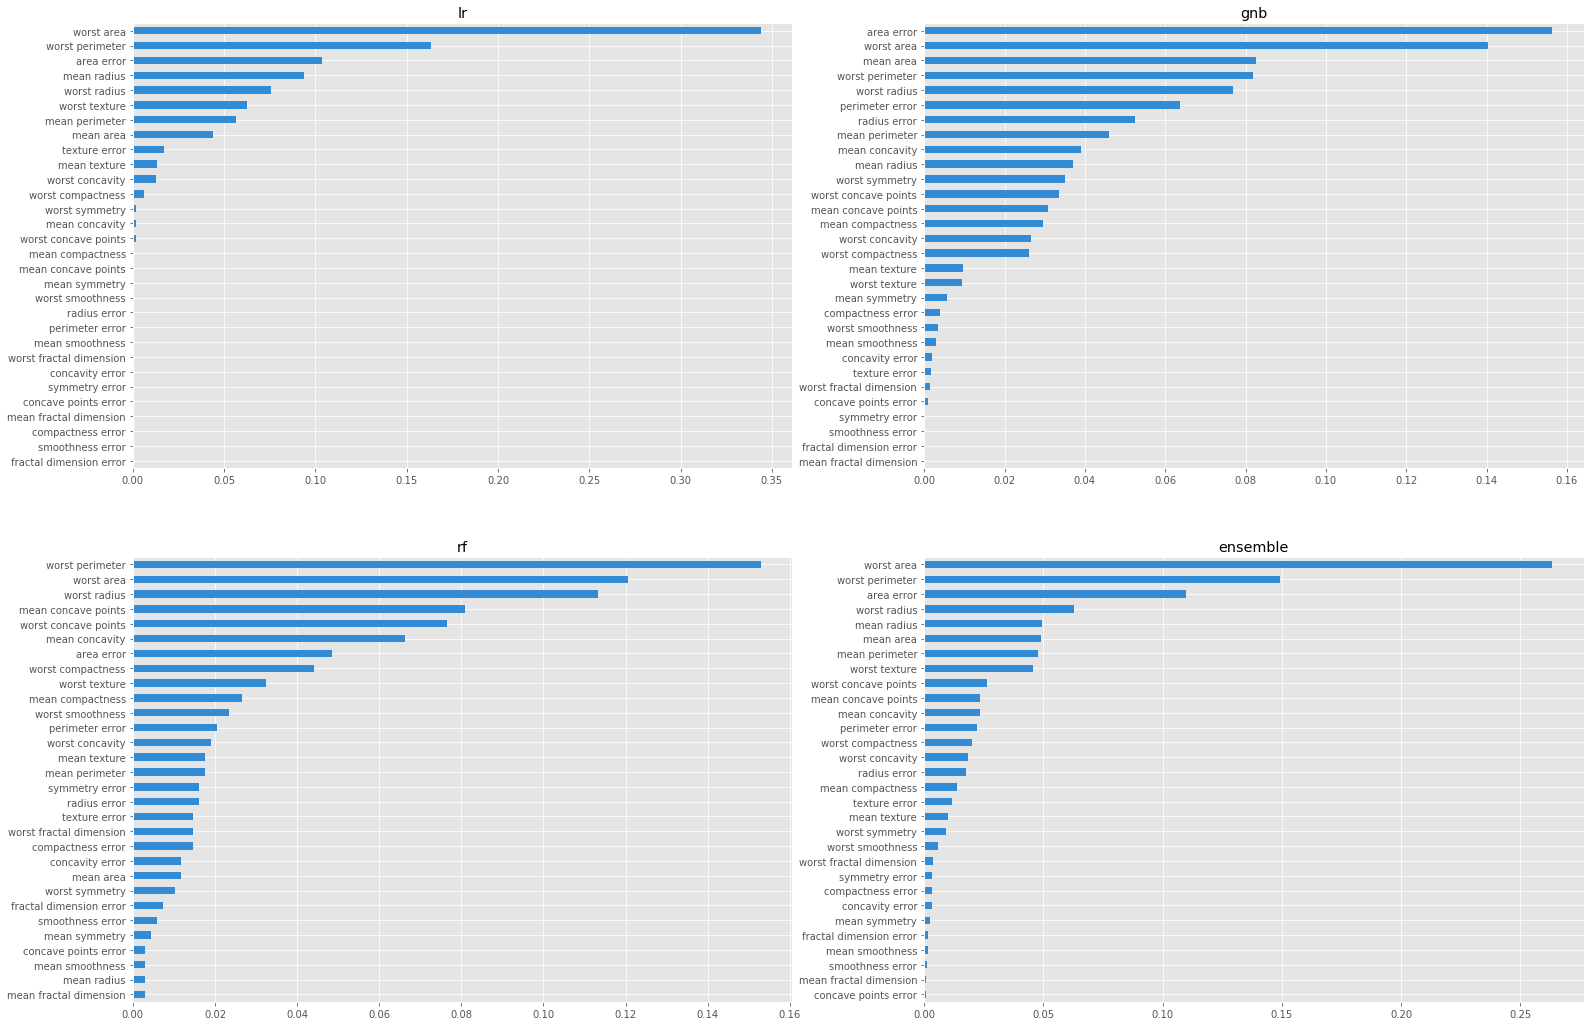

In [8]:
# Ensemble Classifier does not have feature importance enabled by default
f, axes = plt.subplots(2, 2, figsize = (26, 18))

ax_dict = {
    'lr':axes[0][0],
    'rf':axes[1][0],
    'gnb':axes[0][1],
    'ensemble':axes[1][1]
}

interpreter = Interpretation(X_test, feature_names=data.feature_names)

for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_test)
    ax = ax_dict[model_key]
    interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=False, ax=ax)
    ax.set_title(model_key)

In [9]:
# Before interpreting, lets check on the accuracy of all the models
from sklearn.metrics import f1_score
for model_key in models:
        print("Model Type: {0} -> F1 Score: {1}".
              format(model_key, f1_score(y_test, models[model_key].predict(X_test))))

Model Type: gnb -> F1 Score: 0.928571428571
Model Type: rf -> F1 Score: 1.0
Model Type: lr -> F1 Score: 0.957746478873
Model Type: ensemble -> F1 Score: 0.971428571429


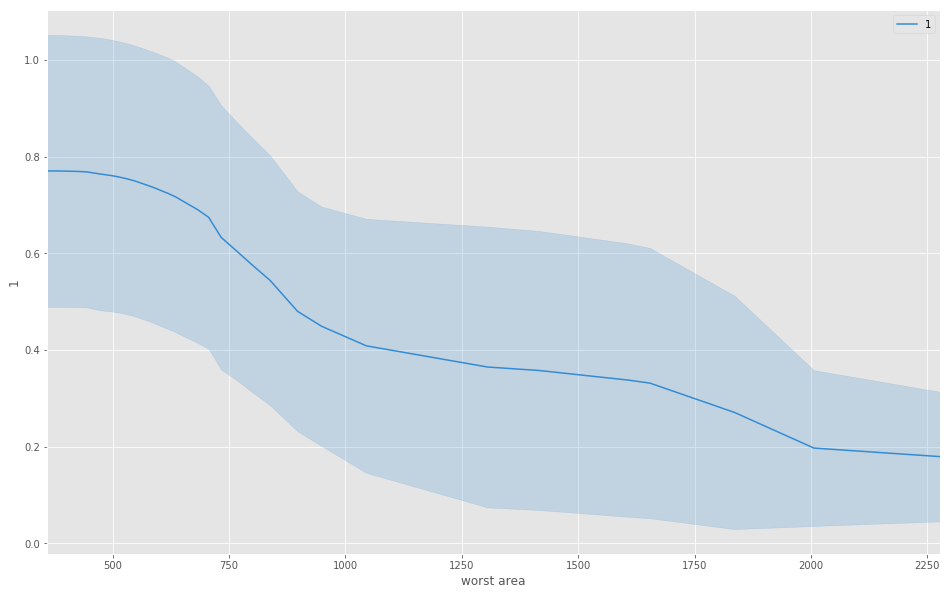

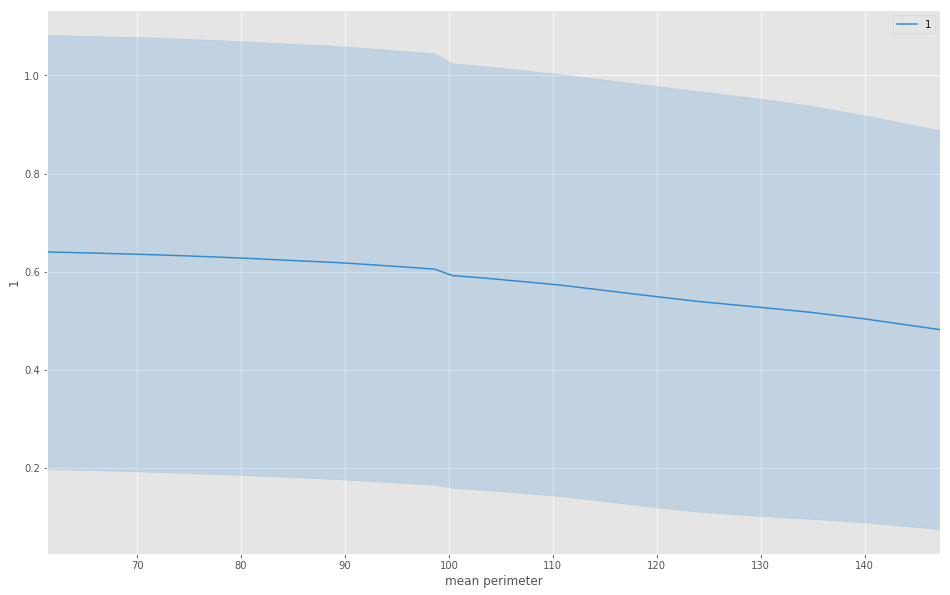

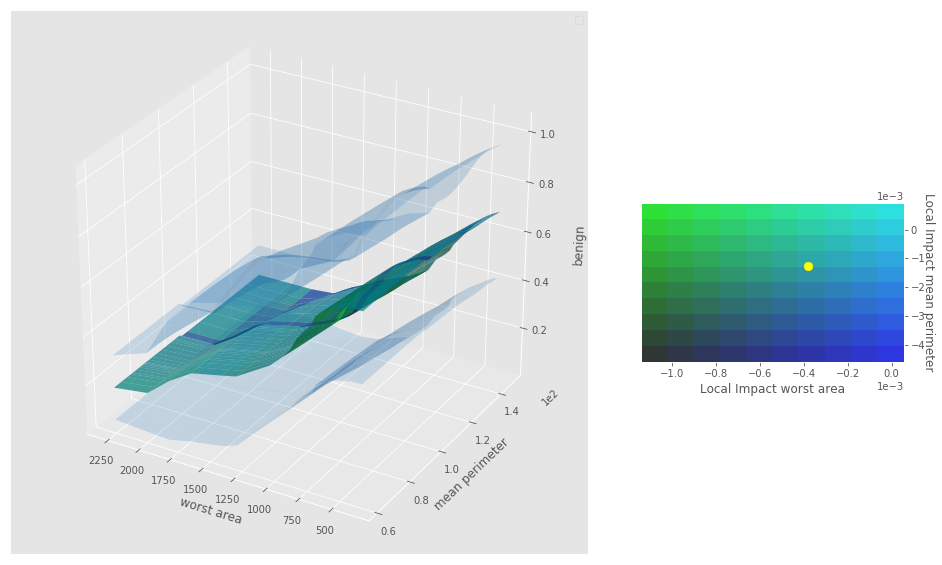

In [10]:
# 1-way interaction of the covariates: 'worst area' and 'mean perimeter'
interpreter.partial_dependence.plot_partial_dependence(['worst area', 'mean perimeter'],
                                                                       pyint_model, 
                                                                       grid_resolution=30, 
                                                                       with_variance=True)

# Lets understand interaction using 2-way interaction using the same covariates
pyint_model = InMemoryModel(eclf.predict_proba, examples=X_test, target_names=data.target_names)
axes_list = interpreter.partial_dependence.plot_partial_dependence([('worst area', 'mean perimeter')],
                                                                       pyint_model, 
                                                                       grid_resolution=30, 
                                                                       with_variance=True)



### To Evaluate a point locally, lets apply Local Interpretation

In [18]:
from random import randint
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
exp = LimeTabularExplainer(X_test, 
                           feature_names=data.feature_names, 
                           discretize_continuous=False, 
                           class_names=['p(No Cancer)', 'p(Cancer)'])

index = randint(0, len(X_test))
print("Model behavior at row: {}".format(index))
# Lets evaluate the prediction from the model and actual target label
print("prediction from the model:{}".format(eclf.predict(X_test[index].reshape(1, -1))))
print("Target Label on the row: {}".format(y_test.reshape(1,-1)[0][index]))

exp.explain_instance(X_test[index], models['ensemble'].predict_proba).show_in_notebook()

Model behavior at row: 25
prediction from the model:[1]
Target Label on the row: 1


## Conclusion:

Using global and local interpretation one is able to understand interactions between independent(input features) and dependent variable(P(Cancer)/P(No Cancer) by querying the model's behavior. 
While Feature Importance helped us in understanding more about the variable weights used by the predictive model. Partial dependence plots and LIME helped us understand interactions between the variables that is driving the prediction.